In [483]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

We're talking about Pile-Up effect of Time-Correlated Single Photon Counting (TCSPC)

---

I try to simplify at my best:
- A laser emits a pulse of light with a certain shape (e.g., gaussian, triangular, custom).  
- The pulse is composed of a certain number of photons (*photons*).  
- Each of these photons has a probability 'r' of reaching the detector, being absorbed and detected.  
- The detector outputs the arrival time-stamp of the very first photon detected.    

What's the distribution of these arrival times?  
This script answers.

---

Created by Davide Brescia

In [484]:
"Graphical parameters"

# The problem is discretized into many time bins (choose a value > 200)
bins = 5000

# ...And analyzed inside a time radius around 'mu'
radius = 5

# PS 1: Just adjust them til the plots are ok
# PS 2: The time unit is arbitrary, you can decide to consider '1' as '1 ps',
# '1 ns' or even '1 min'.

In [485]:
"Laser pulse - Define its shape, its magnitude and its width"

shape       = 'gaussian' # 'gaussian', 'triangular', 'sawtooth', 'rectangle', 'sawtooth_reversed', 'semi-ellipse' or 'custom'
photons     = 2e4        # Total number of photons the pulse is composed of
mu          = 0          # Center of the pulse (just leave it zero).
width       = 1          # Pulse width. For the gaussian is sigma; for the triang/sawt/rect/semi-ellipse is the base

In [486]:
"Here's the pulse amplitude computation. Don't touch, unless 'custom' shape"

if shape == 'gaussian':  
  amp = photons * 2 * radius / (bins * width * np.sqrt(2*np.pi))

elif shape == 'triangular' or shape == 'sawtooth' or shape == 'sawtooth_reversed':
  radius = 5/8 * width                          # In some cases, radius is better to be this one, trust me.
  amp = photons * 4 * radius / (bins * width)

elif shape == 'rectangle':
  radius = 5/8 * width
  amp = photons * 2 * radius / (bins * width)

elif shape == 'semi-ellipse':
  radius = 5/8 * width
  amp = photons * 8 * radius / (bins * width * np.pi)

elif shape == 'custom':
  amp = 0                                       # Here you can touch

In [487]:
"Probability that each emitted photon reaches and triggers the detector"

r = 1e-4

# What value do I choose? 

'r = 1/photons * 0.1'
# This is the famous rule of thumb (known as '10% regime').
# Just 1 laser pulse over 10 is detected, meaning that 9 over 10 are not even 
# noticed by the detector. When it is detected, most probably just one photon of
# the pulse has reached the detector and the photon belonged to whatever part of
# the pulse shape. In this case, by collecting the histogram of the arrival 
# times (TCSPC), you can easily infer the original laser pulse shape. Indeed, 
# the orange and the blue plots are basically equal. 

'r = 1/photons'
# In average, the detector notices each laser pulse. In this case, probably more
# than 1 photon reaches the detector each time. Consequently, since we can just
# collect the time arrivals of the FIRST photon, we have a little distorted
# blue plot, it's not equal to the orange one! Attenuate the laser. 

'r = 0.5'
# Very high probability. Means that each emitted photon has 50% of triggering
# the detector. The histogram of the arrival times is very much distorted with 
# respect to the original pulse shape.

'r = 0.000000000001'
# Very low probability. When the detector detects the pulse (happens very very 
# rarely), we are almost sure that just one photon of the pulse has reached the
# detector (not 2 or more). So, since this photon belonged to a completely 
# random part of the laser pulse shape, the histogram is practically equal to
# the true laser pulse. The drawback is that we need a loooong time to collect 
# enough data for building the histogram. In general, the '10% regime' rule of
# thumb is the optimal trade-off between accuracy and measurement time.  

# Try it for yourself!

'r = 0.000000000001'

In [488]:
# Function used to define the shape of the laser pulse
def laser_pulse_function(x, shape, mu, width, amp):

  # Gaussian
  if shape == 'gaussian':
    y = amp*np.exp(-np.power(x - mu, 2.) / (2 * np.power(width, 2.)))

  # Triangular
  if shape == 'triangular':
    if x < mu - width/2 or x > mu + width/2:
      y = 0
    else:
      y = amp*(1 - 2/width * abs(mu - x))

  # Sawtooth
  if shape == 'sawtooth':
    if x < mu - width/2 or x > mu + width/2:
      y = 0
    else:
      y = amp*(1 - (x - mu + width/2) / width)

  # Rectangle
  if shape == 'rectangle':
    if x < mu - width/2 or x > mu + width/2:
      y = 0
    else:
      y = amp

  # Sawtooth (reversed)
  if shape == 'sawtooth_reversed':
    if x < mu - width/2 or x > mu + width/2:
      y = 0
    else:
      y = amp*(x - mu + width/2) / width
  
  # Semi-ellipse
  if shape == 'semi-ellipse':
    if x < mu - width/2 or x > mu + width/2:
      y = 0
    else:
      y = 2*amp/width * np.sqrt(width**2/4 - (x-mu)**2)

  # Custom function
  if shape == 'custom':
    # You may define here your custom function, if you desire a pulse of another
    # shape. It must be a function of x. Remark: the pulse photons number 
    # depends on the amplitude, width, but also on the radius and number of
    # bins. My suggestion is to guess an amplitude and regulate it by hand until
    # the number of photons (it's calculated above the plot) becomes acceptable.
    y = 0*x                  

  return y

In [489]:
# Function generating the laser pulse values, at the center of each bin
def gen_pulse(bin_centers_, shape, mu, width, amp):

  pulse_values_ = []

  for t in bin_centers_:
    pulse_values_.append(laser_pulse_function(t, shape, mu, width, amp))

  return pulse_values_

In [490]:
# Generate the centers of the bins
bin_centers = []
for i in range(bins):
  bin_centers.append(mu + radius * (2 * i / bins - 1) + radius / bins)

In [491]:
# At each bin center, calculate the value of the laser pulse (number of photons
# emitted in that bin) 
pulse_values = gen_pulse(bin_centers, shape, mu, width, amp)

In [492]:
# Generate the 'histogram' of the arrival times of the photons on the detector.
# Two things:
# 1. The source-detector time-of-flight is supposed 0. In this way, by
#    overlapping the laser pulse and this 'histogram' you can visualize the 
#    point of the laser shape from which the photon comes from.
# 2. This is not a 'histogram', but a probability density vs arrival time. You
#    could see it as a histogram done with +inf data. 

probabilities = []
zero_prob = [1]

for i in range(bins):
  
  t = bin_centers[i]
  N = laser_pulse_function(t, shape, mu, width, amp) # Starting photons from the laser in the i-th bin
  p_zero = (1-r)**N                                  # Probability that none of such photons arrives on the detector
  p_some = 1 - p_zero                                # Probability that one or more of such photons arrive on the detector
   
  p = p_some * zero_prob[-1]                         # Probability that the very-first-photon belongs to the i-th bin
  probabilities.append(p)

  zero_prob.append(p_zero*zero_prob[-1])             # I don't feel like explaining this, sorry :/

In [493]:
# Function that normalizes a list 
def normalize(list_):
  
  normalized = []

  norm = sum(list_)

  for elem in list_:
    normalized.append( elem/norm )
  
  return normalized

In [494]:
# Normalize the two plots, so they have equal area and they are comparable.
# By doing so, the two plots can be seen as probability density functions.
norm_prob = normalize(probabilities)
norm_pulse = normalize(pulse_values)

-------- Parameters --------
Pulse photons:	 20000
Prob. 'r':	 0.0001



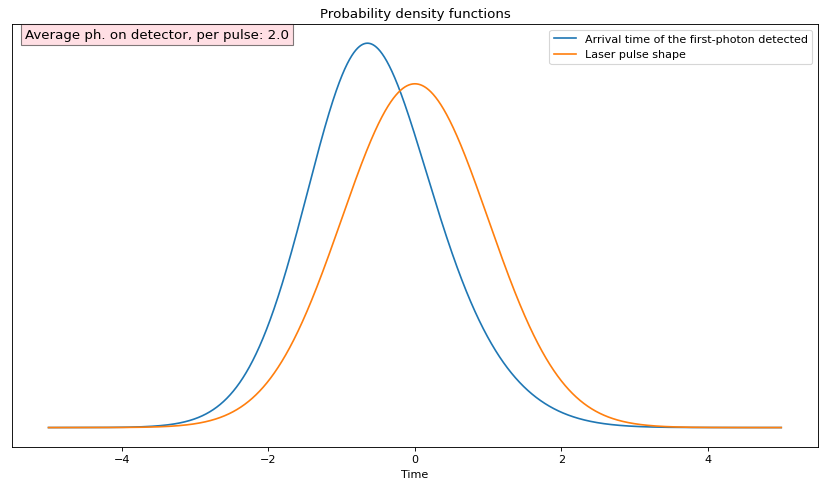

In [495]:
photons_ = sum(pulse_values)    # Photons of the pulse, computed in the brute way. It must be equal to 'photons'. (Used just for double check).
av_det_ph = float(r * photons_) # Average photons that reach the detector, per pulse.

# It seems that 'av_det_ph' is the parameter that matters. (If you double 'photons_', but halve 'r', the normalized plots are the same). 

print("-------- Parameters --------")
print("Pulse photons:\t", int(photons_ + 0.5))
print("Prob. 'r':\t", r)

plot_string = "Average ph. on detector, per pulse: " + "%.1f" % av_det_ph

plt.figure(figsize=(13,7), dpi = 80)
plt.plot(bin_centers, norm_prob)
plt.plot(bin_centers, norm_pulse)
frame1 = plt.gca()
frame1.axes.get_yaxis().set_visible(False)
plt.title("Probability density functions")
plt.xlabel("Time")
plt.legend(['Arrival time of the first-photon detected','Laser pulse shape'])
plt.text(0.18, 0.975, plot_string, horizontalalignment='center', verticalalignment='center', transform=frame1.transAxes, fontsize=12, bbox=dict(facecolor='pink', alpha=0.5))

print()